## Reading the results of the Behavioral Complexity study

In [1]:
import pandas as pd

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

Plot the mean and standard error for test performance metrics as a function of age. Confirm the paper's finding.

In [55]:
df = pd.read_csv('lifespan.csv', sep=' ')
task = 'toss.K'
df.dropna(how='any', inplace=True)
x, y = np.array(df['age']), np.array(df[task])

# sort by x
x, idx = np.unique(x, return_index=True)
y = y[idx]

In [56]:
# predictors
def get_predictors(x, period=80.0):
    return np.stack((
        np.ones(x.size),
        np.sin(1*2*np.pi*x/period),
        np.cos(1*2*np.pi*x/period),
        np.sin(2*2*np.pi*x/period),
        np.cos(2*2*np.pi*x/period),
    ))

Best age: 28.9


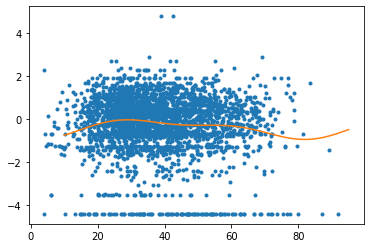

In [57]:
X = get_predictors(x)
fit = y @ X.T @ np.linalg.inv(X @ X.T)
yhat = fit @ X
plt.plot(x, y, '.')

t = np.linspace(10, 95, 100)
Xt = get_predictors(t)
yt = fit @ Xt
plt.plot(t, yt)

best_age = t[yt.max() == yt][0]
print(f'Best age: {best_age:0.1f}')

# Bootstap: Resampling from the data 

Best age: 29.7


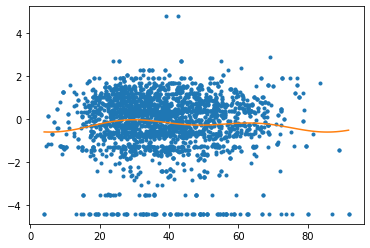

In [58]:
ix = np.random.randint(0, x.size, x.size)  # resampling indices
xx = x[ix]
yy = y[ix]

X = get_predictors(xx)
t = np.linspace(x.min(), x.max(), 100)
Xt = get_predictors(t)

fit = yy @ X.T @ np.linalg.inv(X @ X.T)

plt.plot(xx, yy, '.')
yt = fit @ Xt
plt.plot(t, yt)

best_age = t[yt.max() == yt][0]
print(f'Best age: {best_age:0.1f}')

Text(0.5, 0, 'age')

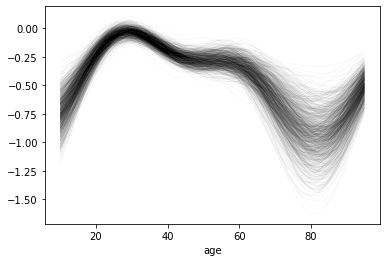

In [59]:
# repeat resampling many times (plotting only)

for i in range(1000):
    ix = np.random.randint(0, x.size, x.size)
    xx = x[ix]
    yy = y[ix]

    X = get_predictors(xx)
    t = np.linspace(10, 95, 100)
    Xt = get_predictors(t)

    fit = yy @ X.T @ np.linalg.inv(X @ X.T)

    yt = fit @ Xt
    plt.plot(t, yt, 'k', alpha=0.1, lw=0.2)

plt.xlabel('age')

# Compute confidence intervals by resampling 

In [60]:
# repeat resampling many times to find lower and upper confidence intervals

yt = []
age = []
for i in range(1000):
    ix = np.random.randint(0, x.size, x.size)
    xx = x[ix]
    yy = y[ix]

    X = get_predictors(xx)
    t = np.linspace(x.min(), x.max(), 100)
    Xt = get_predictors(t)

    fit = yy @ X.T @ np.linalg.inv(X @ X.T)
    yhatt = fit @ Xt
    yt.append(yhatt)
    age.append(t[yhatt==yhatt.max()])

age = np.array(age)
yt = np.stack(yt)
lower, upper = np.percentile(yt, [2.5, 97.5], axis=0)

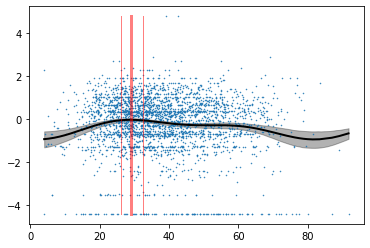

In [61]:
plt.plot(x, y, '.', ms=1)
plt.fill_between(t, lower, upper, color='k', alpha=0.3)
plt.plot(x, yhat, color='k', lw=2)
ixmax = (yhat == yhat.max())
plt.plot([x[ixmax]]*2, [y.min(), y.max()], lw=3, alpha=.5, color='red')
plt.plot([np.percentile(age, 2.5)]*2, [y.min(), y.max()], lw=1, alpha=.5, color='red')
plt.plot([np.percentile(age, 97.5)]*2, [y.min(), y.max()], lw=1, alpha=.5, color='red')

# Binary classifier

In [62]:
x, y

(array([ 4.00273973,  4.02739726,  4.22191781, ..., 86.9260274 ,
        89.01369863, 91.74246575]),
 array([-4.41549456,  2.28223879, -0.69307688, ..., -4.41549456,
        -1.43852977, -4.41549456]))

In [63]:
group = (x > 15) * (x < 60)

In [64]:
group.mean()

0.9058143488609317

In [65]:
group.mean()

0.9058143488609317

Text(0.5, 0, 'performance')

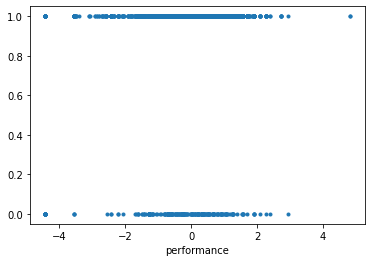

In [66]:
plt.plot(y, group, '.')
plt.xlabel('performance')

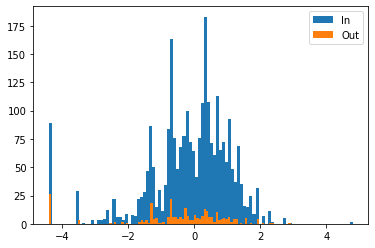

In [67]:
plt.hist(y[group], 100)
plt.hist(y[~group], 100)
plt.legend(('In', 'Out'))

In [68]:
TPR = []
FPR = []
yrange = y.max() - y.min()
for threshold in np.linspace(y.min() - yrange *.1, y.max() + yrange*.1, 100):
    pred = y >= threshold
    TPR.append((pred * group).sum() / group.sum())
    FPR.append(((pred) * (~group)).sum() / (~group).sum())

AUC: 0.064


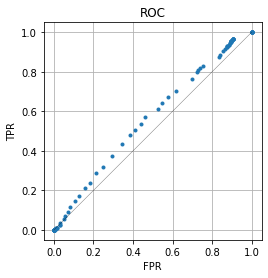

In [69]:
FPR = np.array(FPR)
TPR = np.array(TPR)
plt.plot(FPR, TPR, '.')
plt.plot([0, 1], [0, 1], 'k', alpha=0.5, lw=0.5)
plt.axis('square')
plt.grid(True)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC');

AUC = np.sum(((TPR - FPR)[:-1] + (TPR - FPR)[1:])/2 * (FPR[:-1] - FPR[1:]))
print(f'AUC: {AUC:0.2}')

# Using features for logistic regression

In [70]:
df.columns

Index(['sex', 'age', 'field', 'language', 'education', 'paranormal', 'toss.K',
       'toss.RT', 'grid.K', 'grid.RT', 'guess.K', 'guess.RT', 'roll.K',
       'roll.RT', 'spot.K', 'spot.RT', 'K', 'toss', 'guess', 'roll', 'spot',
       'grid', 'RT'],
      dtype='object')

In [24]:
df['spot.K']

0      -15.152845
1        1.990685
2        1.516013
3      -15.152845
4        1.999894
          ...    
3444     1.928088
3445     1.887173
3446     2.174029
3447     1.893948
3448     1.866303
Name: spot.K, Length: 3382, dtype: float64

In [78]:
t = np.array(df['age'])
x1 = np.array(df['toss.K'])
x2 = np.array(df['grid.K'])
x3 = np.array(df['roll.K'])
x4 = np.array(df['spot.K'])

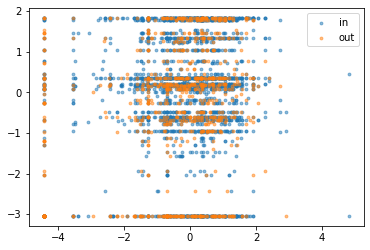

In [93]:
group = (t > 20) * (t < 50)
plt.scatter(x1[group], x2[group], s=8, alpha=.5)
plt.scatter(x1[~group], x2[~group], s=8, alpha=.5)
plt.legend(("in", "out"))

In [94]:
group.mean()

0.7471910112359551

In [95]:
from sklearn.linear_model import LogisticRegression

X = np.stack((x1, x2, x3, x4)).T

y = group

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

y_ = log_reg.predict(X)

In [96]:
(y == y_).mean()

0.7480780603193377